# Homework6: Evaluation of implicit models + discrete VAE.

## Task 1: Theory (4pt)

### Problem 1: Neural ODE vs backprop (2pt)

At Lecture 12 we have discussed [Neural ODE](https://arxiv.org/pdf/1806.07366.pdf) model. There we used the adjoint state functions
$$
	\mathbf{a}_{\mathbf{z}}(t) = \frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t)}; \quad \mathbf{a}_{\boldsymbol{\theta}}(t) = \frac{\partial L(\mathbf{y})}{\partial \boldsymbol{\theta}(t)}.
$$

These two functions allowed to derive continuous version of backpropagation algorithm.

The formulas for the method are given by Pontryagin theorem. It claims that
$$
	\frac{d \mathbf{a}_{\mathbf{z}}(t)}{dt} = - \mathbf{a}_{\mathbf{z}}(t)^T \cdot \frac{\partial f(\mathbf{z}(t), t, \boldsymbol{\theta})}{\partial \mathbf{z}}
$$

$$ 
    \frac{d \mathbf{a}_{\boldsymbol{\theta}}(t)}{dt} = - \mathbf{a}_{\mathbf{z}}(t)^T \cdot \frac{\partial f(\mathbf{z}(t), t, \boldsymbol{\theta})}{\partial \boldsymbol{\theta}}.
$$

Your task here is to prove the first formula for $\frac{d \mathbf{a}_{\mathbf{z}}(t)}{dt}$.

**Hints**: you have to use 3 facts

1. Notion of the limit:
$$
    \frac{d \mathbf{a}_{\mathbf{z}}(t)}{dt} = \lim_{\varepsilon \rightarrow +0} \frac{\mathbf{a}_{\mathbf{z}}(t + \varepsilon) - \mathbf{a}_{\mathbf{z}}(t)}{\varepsilon}.
$$

2. Chain rule:
$$
    \frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t)} = \frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t + \varepsilon)} \cdot \frac{\mathbf{z}(t + \varepsilon)}{\partial \mathbf{z}(t)}.
$$
3. Tailor series for 
$$
    \mathbf{z}(t + \varepsilon) = \int_{t}^{t + \varepsilon} f(\mathbf{z}(t), t, \boldsymbol{\theta}) d t + \mathbf{z}(t).
$$

```your solution```

### Problem 2: Gumbel-Max trick (2pt)

In this problem you have to prove the Gumbel-Max trick that we have discussed on the Lecture 12. 

Let $\pi_1, \pi_2, \dots \pi_K, \in (0, 1)$ and $\sum\limits_{k = 1}^{K} \pi_k = 1$. Consider the discrete random variable:

$$
  c = \arg\max_{k} \left[\log \pi_k + g_k\right].
$$

In the formula above $g_k$ ($k \in \{1, \dots K\}$) are independent random variables distributed following the $\text{Gumbel}(0, 1)$ distribution ([wiki](https://en.wikipedia.org/wiki/Gumbel_distribution)), i.e. $g_k \sim \text{Gumbel}(0, 1)$.

Note that $g_k = - \log (- \log u)$, where $u \sim \text{Uniform}[0, 1]$.

Our goal is to prove that $c \sim \text{Categorical}(\pi_1, \dots \pi_K)$.

1. Find cumulative distribution function ($F_{g}(x) = P(g < x)$) of Gumbel distribution.

2. Find density of the Gumbel distribution (derivative of cdf).

3. Consider random variables $\zeta_k = \log \pi_k + g_k$. Let's fix $k^* \in \{1, \dots K\}$ and look at the following probability $P\bigl( \{\zeta_{k} \leq \zeta_{k^*}\} \text{ for all } k \neq k^*\bigr)$. Prove that 

$$
  P\bigl( \bigcap\limits_{k \neq k^*} \{\zeta_{k} \leq \zeta_{k^*}\}\bigr) = \pi_{k^*}.
$$


```your solution```

In [ ]:
!pip install --upgrade --no-cache-dir gdown

REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!mv ./{REPO_NAME}/homeworks/stylegan.py ./stylegan.py
!mv ./{REPO_NAME}/homeworks/inception.py ./inception.py
!rm -Rf {REPO_NAME}

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from inception import InceptionV3

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)


USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: False


/Users/andreichekunov/miniforge3/envs/hard_ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/andreichekunov/miniforge3/envs/hard_ml/lib/python3.10/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE'
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import seaborn as sns
sns.set_theme("paper")

device = torch.device("mps")

import sys
sys.path.append('../../homeworks')

from dgm_utils import train_model, show_samples, plot_training_curves
from dgm_utils import visualize_images, load_dataset

## Task 2: Inception Score and FID (4pt)

Here our goal is to understand how to evaluate likelihood-free models using [Inception Score](https://arxiv.org/pdf/1606.03498.pdf) and [Frechet Inception Distance](https://arxiv.org/pdf/1706.08500.pdf).

In [4]:
# do not change this function
def plot_losses(losses: np.ndarray, title: str) -> None:
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


# this is a helper function that we will use further
def resize_tensor(x: torch.Tensor, image_size: int) -> torch.Tensor:
    return F.interpolate(
        x, size=(image_size, image_size), mode="bilinear", align_corners=False
    )

Your task is to implement the *Inception score* and *FID* score and estimate the quality of two trained *StyleGAN* models we have discussed on Seminar 11 and Seminar 12: 

1. `stylegan_wgangp` is a *StyleGAN* model trained with *WGAN-GP* loss on CIFAR10 dataset ([ckpt_link](https://drive.google.com/file/d/1bTDbmleLXowuGcahsoSBeihSVbGgW52X/view?usp=sharing))

2. `stylegan_r1` is a *StyleGAN* model trained with standard gan loss with $R_1$ regularization on CIFAR10 dataset ([ckpt_link](https://drive.google.com/file/d/1PNeESbetxazQkBJbBnoizyWgGKJwfpW5/view?usp=sharing))

In [5]:
# loading models checkpoints
!gdown --id 1bTDbmleLXowuGcahsoSBeihSVbGgW52X
!gdown --id 1PNeESbetxazQkBJbBnoizyWgGKJwfpW5

/Users/andreichekunov/.pyenv/versions/3.8.13/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bTDbmleLXowuGcahsoSBeihSVbGgW52X
To: /Users/andreichekunov/andrei/machine_learning/mipt_materials/2022-2023-DGM-MIPT-course/homeworks/stylegan_wgangp_loss_FINAL.pth
100%|███████████████████████████████████████| 1.36M/1.36M [00:08<00:00, 156kB/s]
/Users/andreichekunov/.pyenv/versions/3.8.13/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PNeESbetxazQkBJbBnoizyWgGKJwfpW5
To: /Users/andreichekunov/andrei/machine_learning/mipt_materials/2022-2023-DGM-MIPT-course/homeworks/stylegan_gan_r1_

In [6]:
from stylegan import MicroStyleGANGenerator
from copy import deepcopy

sg_wgangp_name = "stylegan_wgangp_loss_FINAL.pth"
sg_gan_r1_name = "stylegan_gan_r1_loss_FINAL.pth"


stylegan_wgangp = MicroStyleGANGenerator(
    z_dim=128,
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=3,
    kernel_size=3,
    hidden_chan=32,
)

stylegan_r1 = deepcopy(stylegan_wgangp)

stylegan_wgangp.load_state_dict(
    torch.load("./{}".format(sg_wgangp_name), map_location="cpu")["generator"]
)

stylegan_r1.load_state_dict(
    torch.load("./{}".format(sg_gan_r1_name), map_location="cpu")["generator"]
)

<All keys matched successfully>

Let's look at model samples from `stylegan_r1`.

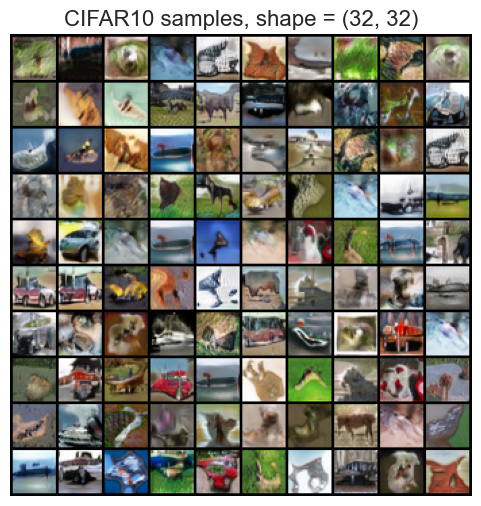

In [7]:
batch = stylegan_r1.sample(100).detach().cpu().numpy()
show_samples(batch, "CIFAR10 samples, shape = ({0}, {0})".format(32), nrow=10)

Let's look at model samples from `stylegan_wgangp`.

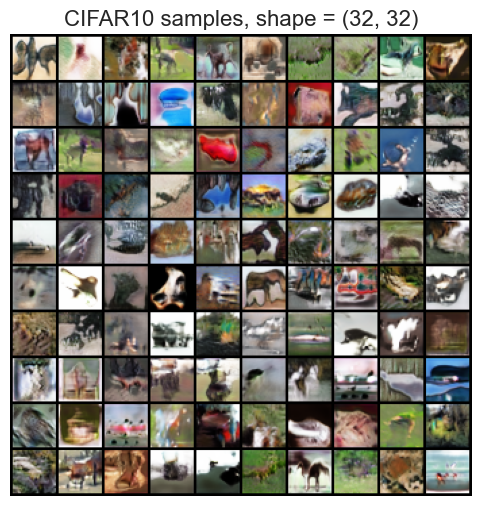

In [8]:
batch = stylegan_wgangp.sample(100).detach().cpu().numpy()
show_samples(batch, "CIFAR10 samples, shape = ({0}, {0})".format(32), nrow=10)

###  Inception Score

The formula for Inception Score is
$$
    \text{IS} = \exp \bigl( \mathbb{E}_{\mathbf{x}} KL(p(y | \mathbf{x}) || p(y)) \bigr),
$$

where 
* $p(y | \mathbf{x})$ is a pretrained classification model with labels $y$ (we will use [Inception V3 model](https://pytorch.org/vision/main/generated/torchvision.models.inception_v3.html));
* $p(y) = \int p(y | \mathbf{x}) p(\mathbf{x}) d \mathbf{x}$ is a marginal distribution on labels.

In order to calculate the **Inception** score we will use `InceptionV3` last layer activations (those before computing `Softmax`). The dimensionality of these activations is $1008$.

Let initialize our classification model.

In [10]:
DIMS = 1008
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[DIMS]
inception_model_act5 = InceptionV3([block_idx])
if USE_CUDA:
    inception_model_act5 = inception_model_act5.cuda()
inception_model_act5 = inception_model_act5.to(device)
inception_model_act5.eval()

Downloading: "https://github.com/w86763777/pytorch-gan-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /Users/andreichekunov/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

We need to get class probabilities from our classification model.

In [13]:
def get_inception_probs(x: torch.Tensor, model: object) -> np.ndarray:
    # ====
    # your code
    # apply model and get probs (apply softmax)
    res = model(x)
    probs = F.softmax(res)
    # ====
    return probs.data.detach().cpu().numpy()


def test_get_inception_probs():
    x = torch.zeros(size=(1, 3, 10, 10))
    if USE_CUDA:
        x = x.cuda()
    x = x.to(device)
    probs = get_inception_probs(x, inception_model_act5)
    true_probs = np.array(
        [
            0.00012616384,
            0.00031305864,
            0.00019984621,
            0.00024997862,
            0.00005619833,
            0.00010180601,
            0.00002303111,
            0.0001946776,
            0.0015921608,
            0.000064336535,
        ]
    )
    assert np.allclose(probs[0, :10], true_probs)


test_get_inception_probs()

/var/folders/jl/zcvdd3rn02b2b7k5d7swxqmr0000gn/T/ipykernel_52635/3673317883.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(res)


In [19]:
# this is a helper function that generates samples from the StyleGAN generator
def generate_fake_images_stylegan(
    sg_generator: object, n_samples: int, batch_size: int
) -> np.ndarray:
    fake_images = []
    for i in range(n_samples // batch_size):
        fake_samples = sg_generator.sample(batch_size).cpu().detach().numpy()
        fake_images.extend(fake_samples)

    fake_samples = sg_generator.sample(n_samples % batch_size).cpu().detach().numpy()
    fake_images.extend(fake_samples)
    return np.array(fake_images)

It is the main function for getting Inception Score.

In [70]:
def get_inception_score(
    generator: object,
    inception_model: object,
    n_samples: int,
    batch_size: int = 32,
    splits: int = 10,
) -> np.ndarray:
    if USE_CUDA:
        generator = generator.cuda()
        inception_model = inception_model.cuda()
    
    generator = generator.to(device)
    inception_model = inception_model.to(device)
    
    generator.eval()
    inception_model.eval()

    fake_images = generate_fake_images_stylegan(generator, n_samples, batch_size)
    loader = torch.utils.data.DataLoader(fake_images, batch_size=batch_size)

    # ====
    # your code
    # get probs of size [n_samples x 1000] for the fake_samples
    
    
    probs = np.zeros((n_samples, 1008))

    for i, batch in enumerate(loader):
        batch_size_i = batch.size()[0]
        probs[i*batch_size:i*batch_size + batch_size_i] = get_inception_probs(batch.to(device), inception_model_act5)
        
    # ====

    split_scores = []
    for k in range(splits):
        part = probs[k * (n_samples // splits) : (k + 1) * (n_samples // splits), :]
        # ====
        # your code
        # 1) calculate p_y mean value of the current part
        # 2) calculate KL (use could you entropy function from scipy)
        # 3) exponentiate it
        py = part.mean(axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_score = np.exp(np.mean(scores))
        # ====
        split_scores.append(split_score)

    return np.mean(split_scores)

In [71]:
N_SAMPLES = 1000
BATCH_SIZE = 16
SPLITS = 5

reset_seed()

IS_stylegan_r1 = get_inception_score(
    generator=stylegan_r1,
    inception_model=inception_model_act5,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
    splits=SPLITS,
)

reset_seed()

IS_stylegan_wgangp = get_inception_score(
    generator=stylegan_wgangp,
    inception_model=inception_model_act5,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
    splits=SPLITS,
)

/var/folders/jl/zcvdd3rn02b2b7k5d7swxqmr0000gn/T/ipykernel_52635/3673317883.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(res)


In [73]:
assert np.allclose(IS_stylegan_r1, 6.566, atol=0.1)
assert np.allclose(IS_stylegan_wgangp, 6.63, atol=0.1)

**In case you have free time**: You are free to evaluate the models from the previous homework via Inception-score.

In [ ]:
# Inception scores of your nice models which beat StyleGAN
...

###  Frechet Inception Distance

Now we will implement Frechet Inception Distance:

$$
	\text{FID} (\pi, p) = \| \mathbf{m}_{\pi} - \mathbf{m}_{p}\|_2^2 + \text{Tr} \left( \boldsymbol{\Sigma}_{\pi} + \boldsymbol{\Sigma}_p - 2 \sqrt{\boldsymbol{\Sigma}_{\pi} \boldsymbol{\Sigma}_p} \right)
$$

* Representations are the outputs of the intermediate layer from the pretrained classification model (we will use the activations of the last by one layer of `InceptionV3` (which have dimensionality $(2048, 1, 1)$), that's why the last two dimensions should be dropped before FID statistics calculation).
* $\mathbf{m}_{\pi}$, $\boldsymbol{\Sigma}_{\pi} $ are the mean vector and the covariance matrix of feature representations for samples from $\pi(\mathbf{x})$
* $\mathbf{m}_{p}$, $\boldsymbol{\Sigma}_p$ are the mean vector and the covariance matrix of feature representations for samples from $p(\mathbf{x} | \boldsymbol{\theta})$.

Let initialize our classification model which outputs last by one activations:

In [74]:
DIMS = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[DIMS]
inception_model_act4 = InceptionV3([block_idx])
if USE_CUDA:
    inception_model_act4 = inception_model_act4.cuda()
inception_model_act4.eval()

InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

Here we need samples from the ground truth distribution $\pi(\mathbf{x})$ (CIFAR10 images).

Files already downloaded and verified
Files already downloaded and verified


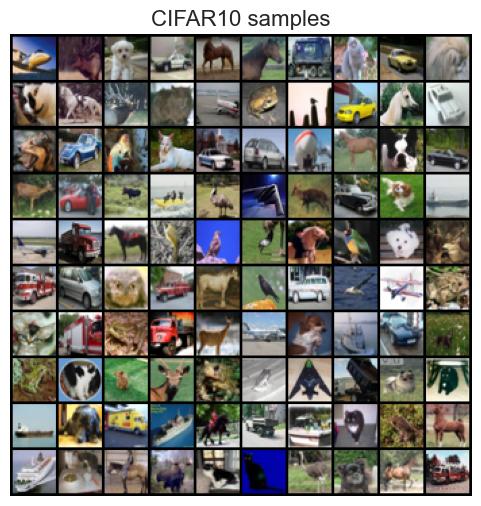

In [75]:
train_data, test_data = load_dataset("cifar10", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

Let implement function to take square root of matrix (we need it for the formula above).

In [160]:
# this is a helper function, do not change
def get_matrix_sqrt(x: torch.Tensor) -> torch.Tensor:
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    if not np.isfinite(y).all():
        print("bad!")
    return torch.Tensor(y.real, device=x.device)

Not let implement the function to calculate the distance (it is just the formula above).

In [239]:
def get_distance(
    mu_x: torch.Tensor, mu_y: torch.Tensor, sigma_x: torch.Tensor, sigma_y: torch.Tensor
) -> torch.Tensor:
    # ====
    # your code
    #dist = torch.linalg.vector_norm(mu_x - mu_y)**2 + torch.trace(sigma_x + sigma_y - 2*get_matrix_sqrt(sigma_x*sigma_y))
    dist = torch.linalg.vector_norm(mu_x - mu_y)**2 + torch.trace(sigma_x + sigma_y - 2*torch.sqrt(sigma_x*sigma_y))

    return dist
    # ====
     

def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3) * 10
    sigma_x = torch.eye(3) * 5
    sigma_y = torch.eye(3) * 3
    
    dist = get_distance(mu_x, mu_y, sigma_x, sigma_y)
    assert np.isclose(dist, 243.7621)


test_get_distance()

In [240]:
def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3)
    sigma_x = torch.eye(3) * 3
    sigma_y = torch.eye(3) * 3
    print(get_distance(mu_x, mu_y, sigma_x, sigma_y))

test_get_distance()

tensor(0.)


Let implement the function which calculate intermediate representations for real and fake samples.

In [162]:
a = torch.randn(4, 4, 4)
c = a.view(a.shape[0], a.shape[-1]*a.shape[-2])
a.shape, c.shape

(torch.Size([4, 4, 4]), torch.Size([4, 16]))

In [249]:
def get_features(
    generator: object,
    inception_model: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> tuple:
    if USE_CUDA:
        generator = generator.cuda()
        inception_model.cuda()

    generator = generator.to(device)
    inception_model = inception_model.to(device)
    
    generator.eval()
    inception_model.eval()

    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_samples in loader:
            # real_samples = resize_tensor(real_samples, image_size)
            if USE_CUDA:
                real_samples = real_samples.cuda()
            real_samples = real_samples.to(device)    
            # ====
            # your code
            # get features of real samples
            # drow the w and h dimensions of the obtained features
            real_features = inception_model(real_samples)
            real_features = real_features.view(real_features.shape[0], 
                                               real_features.shape[1])

            # ====
            #print(real_features.shape)
            real_features_list.append(real_features)

            fake_samples = generator.sample(len(real_samples), step=3)
            # fake_samples = resize_tensor(fake_samples, image_size)
            if USE_CUDA:
                fake_samples = fake_samples.cuda()
            fake_samples = fake_samples.to(device)
            # ====
            # your code
            # get features of fake samples
            # drop the w and h dimensions of the the obtained features
            fake_features = inception_model(fake_samples)
            fake_features = fake_features.view(fake_features.shape[0], 
                                               fake_features.shape[1])
            

            # ====
            fake_features_list.append(fake_features)

            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    return fake_features_all, real_features_all

In [250]:
# this is a helper function, do not change
def calculate_stats(fake_features: torch.Tensor, real_features: torch.Tensor) -> tuple:
    def get_covariance(features):
        return torch.Tensor(np.cov(features.detach().cpu().numpy(), rowvar=False))

    mu_fake = fake_features.mean(0)
    mu_real = real_features.mean(0)
    sigma_fake = get_covariance(fake_features)
    sigma_real = get_covariance(real_features)
    return mu_fake, mu_real, sigma_fake, sigma_real

Now we are ready to implement the main function for getting FID.

In [251]:
def get_frechet_inception_distance(
    generator: object,
    inception_model: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> torch.Tensor:
    # ====
    # your code
    # 1) get features
    # 2) calculate stats
    # 3) get distance
    fake_features_all, real_features_all = get_features(generator, inception_model, 
                                                        loader, n_samples, batch_size)
    mu_fake, mu_real, sigma_fake, sigma_real = calculate_stats(fake_features_all, real_features_all)
    
    dist = get_distance(mu_fake, mu_real, sigma_fake, sigma_real)
    return dist
    # ====

In [254]:
N_SAMPLES = 10000  # number of samples in the cifar10 test dataset
BATCH_SIZE = 16  # samples per iteration

gt_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

reset_seed()

FID_r1 = get_frechet_inception_distance(
    generator=stylegan_r1,
    inception_model=inception_model_act4,
    loader=gt_loader,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
)

reset_seed()

FID_wgangp = get_frechet_inception_distance(
    generator=stylegan_wgangp,
    inception_model=inception_model_act4,
    loader=gt_loader,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
)

In [255]:
FID_r1, FID_wgangp

(tensor(16.6514, device='mps:0'), tensor(18.6616, device='mps:0'))

In [ ]:
assert np.allclose(FID_r1, 48.35, atol=0.2)
assert np.allclose(FID_wgangp, 48.4, atol=0.2)

**In case you have free time**: You are free to evaluate the models from the previous homework via FID-score.

In [ ]:
# FID scores of your nice models which beat StyleGAN
...

## Task 3: VQ-VAE (5 pt)

### Training of VQ-VAE model

In this part you will train [VQ-VAE](https://arxiv.org/abs/1711.00937) model that we have discussed at Lecture 12 (see also [VQ-VAE-2](https://arxiv.org/abs/1906.00446) paper). 

We will you MNIST dataset in this task. 

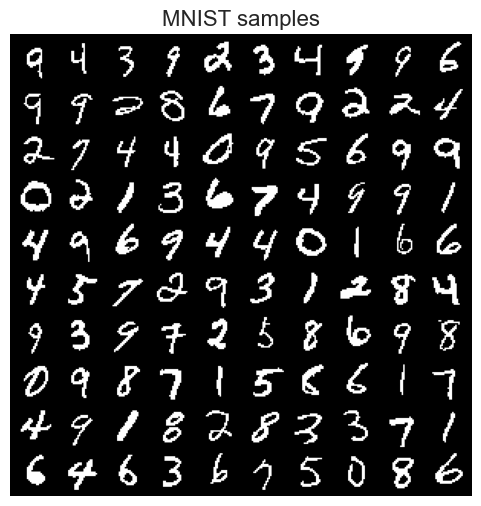

In [431]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data, "MNIST samples")

In [371]:
train_data[0].shape

(1, 28, 28)

In [440]:
train_data[0].min(), train_data[0].max()

(0.0, 1.0)

# VQ-VAE model is a VAE model with discrete latent variable.  

**Reminder:**
* We define  dictionary (word book) space $\{\mathbf{e}_k\}_{k=1}^K$, where $\mathbf{e}_k \in \mathbb{R}^C$, $K$ is the size of the dictionary. 
* $\mathbf{z}_e = \text{NN}_e(\mathbf{x}, \boldsymbol{\phi})$ - continuous output of encoder network.
* $\mathbf{z}_q = \mathbf{e}_{k^*}$ is a quantized representation, where $k^* = \text{argmin}_k \| \mathbf{z} - \mathbf{e}_k \|$. It is simple nearest neighbor look up.
* Out deterministic variational posterior:
$$
  q(c = k^* | \mathbf{x}, \boldsymbol{\phi}) = \begin{cases}
  1 , \quad \text{for } k^* = \text{argmin}_k \| \mathbf{z}_e - \mathbf{e}_k \|; \\
  0, \quad \text{otherwise}.
\end{cases}
$$
* Prior distribution is uniform: $p(c) = \text{Uniform}\{1, \dots, K\}$.
* KL divergence between posterior and prior:
$$
  KL(q(c = k^* | \mathbf{x}, \boldsymbol{\phi}), p(c)) = \log K.
$$ 
* ELBO:
$$
		\mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta})  = \mathbb{E}_{q(c | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{e}_{c} , \boldsymbol{\theta}) - \log K =  \log p(\mathbf{x} | \mathbf{z}_q, \boldsymbol{\theta}) - \log K.
$$
* Vector quantization is non-differentiable operation. We will use **straight-through** gradient estimator (we will copy gradients from decoder input $\mathbf{z}_q$ to encoder output $\mathbf{z}_e$.

**Important modifications:**
Due to the straight-through gradient estimation of mapping from $\mathbf{z}_e$ to $\mathbf{z}_q$, the embeddings $\mathbf{e}$ receive no gradients from the ELBO. 

Therefore, in order to learn the embedding space we add l2 loss (**codebook loss**) to move the embedding vectors $\mathbf{e}$ towards the encoder outputs $\mathbf{z}_e$. 

Finally, since the volume of the embedding space is dimensionless, it can grow arbitrarily if the embeddings $\mathbf{e}$ do not train as fast as the encoder parameters. To make sure the encoder commits to an embedding and its output does not grow, we add a **commitment loss**.

Thus, the total training objective becomes:
$$
  \log p(\mathbf{x}| \mathbf{z}_q, \boldsymbol{\theta}) + \| \text{stop_gradient}(\mathbf{z}_e) - \mathbf{e}\|_2^2 + \| \mathbf{z}_e - \text{stop_gradient}(\mathbf{e})\|_2.
$$

Pay attention to the $\text{stop_gradient}(*)$ operator.


Our first step is implement vector quantization procedure. It will also calculate two consistency losses.

In [285]:
embeddings = torch.randn(100, 16)
y = torch.randn(32, 3, 3, 16)

encoding_indices = torch.argmin(torch.cdist(y, embeddings), -1)
embeddings[encoding_indices].shape

torch.Size([32, 3, 3, 16])

In [556]:
class VectorQuantizer(nn.Module):
    def __init__(
        self, num_embeddings: int = 128, embedding_dim: int = 16, beta: float = 0.25
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        # Initialize the embeddings which we will quantize.
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def get_code_indices(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape[:-1]
        flattened = x.view(-1, self.embedding_dim)
        
        # ====
        # your code
        # 1) calculate distances from flatten inputs to embeddings
        # 2) find nearest embeddings to each input (use argmin op)
        
        # Derive the indices for minimum distances.
        encoding_indices = torch.argmin(torch.cdist(flattened, self.embedding.weight), -1)

        # ====
        encoding_indices = encoding_indices.view(input_shape)
        return encoding_indices

    def get_quantized(self, encoding_indices: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) get embeddgins with appropriate indices
        # 2) transform tensor from BHWC to BCHW format
        quantized = self.embedding.weight[encoding_indices]
        quantized = quantized.permute(0, 3, 1, 2).contiguous()                                
        # ====
        return quantized

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) get indices
        # 2) get quantized latents
        # 3) calculate codebook and commitment loss
        #    do not afraid about stop_gradient op
        #    (use .detach() method for quantized latents and x)
        # 4) final loss is codebook_loss + beta * commitment_loss
       
        encoding_indices = self.get_code_indices(x)
        quantized = self.get_quantized(encoding_indices)

        #codebook_loss = torch.norm(x.detach() - quantized)**2
        #commitment_loss = torch.norm(quantized.detach() - x)**2
        
        codebook_loss = F.mse_loss(x.detach(), quantized)
        commitment_loss = F.mse_loss(quantized.detach(), x)
        
        #codebook_loss = torch.mean(torch.norm((x.detach() - quantized)**2, 2, 1))
        #commitment_loss = torch.mean(torch.norm((quantized.detach() - x)**2, 2, 1))
        
        loss = codebook_loss + self.beta * commitment_loss
        # ====

        # Straight-through estimator (think about it!).
        quantized = x + (quantized - x).detach()

        return quantized, loss


def test_vector_quantizer():
    x = torch.zeros((1, 16, 7, 7))
    x = torch.ones((1, 16, 7, 7))
    layer = VectorQuantizer()
    indices = layer.get_code_indices(x)
    
    assert indices.shape == (1, 7, 7)
    quantized = layer.get_quantized(indices)
    assert quantized.shape == (1, 16, 7, 7)
    quantized, loss = layer(x)
    assert quantized.shape == (1, 16, 7, 7)
    assert loss.shape == ()

test_vector_quantizer()

We will use simple encoder/decoder with several strided convolutions.

In [751]:
w = 28
k = 4


#for s, p in zip([2, 2, 1], [2, 2, 1]):
for s, p in zip([2, 2], [1, 1]):
    w = (w - k + 2*p)/s + 1
    print(int(w))

14
7


In [752]:
w = 7
k = 4

#for s, p in zip([1, 1, 2], [0, 0, 0]):
for s, p in zip([2, 2], [1, 1]):
    w = (w - 1)*s -2*p + (k -1 ) + 1
    print(int(w))

14
28


In [755]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with Conv2d and ReLU activation
        
        self.net = nn.Sequential(nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(8, latent_dim, kernel_size=4, stride=2, padding=1),
                                 nn.ReLU()
                                )
        
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with ConvTransposed2d and ReLU activation

        self.net = nn.Sequential(nn.ConvTranspose2d(latent_dim, 8, kernel_size=4, stride=2, padding=1),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(8, 2, kernel_size=4, stride=2, padding=1),
                                 nn.ReLU(),
                                )
        # ====

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


In [750]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with Conv2d and ReLU activation
        
        self.net = nn.Sequential(nn.Conv2d(1, 4, kernel_size=4, stride=2, padding=2),
                                 nn.ReLU(),
                                 nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=2),
                                 nn.ReLU(),
                                 nn.Conv2d(8, latent_dim, kernel_size=4, stride=1, padding=1),
                                 nn.ReLU()
                                )
        
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with ConvTransposed2d and ReLU activation

        
        self.net = nn.Sequential(nn.ConvTranspose2d(latent_dim, 8, kernel_size=4, stride=1, padding=0),
                         nn.ReLU(),
                         nn.ConvTranspose2d(8, 4, kernel_size=4, stride=1, padding=0),
                         nn.ReLU(),
                         nn.ConvTranspose2d(4, 2, kernel_size=4, stride=2, padding=0),
                         nn.ReLU()
                        )
        # ====

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)

Now we are ready to define our model. It consists of encoder, decoder and vector quatizer.

In [756]:
class VQVAEModel(nn.Module):
    def __init__(
        self,
        ce_loss_scale: float = 1.0,
        latent_dim: int = 16,
        num_embeddings: int = 64,
        latent_size: tuple = (7, 7),
    ) -> None:
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, latent_dim)
        self.ce_loss_scale = ce_loss_scale
        self.latent_size = latent_size
        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) apply encoder
        # 2) apply vector quantizer (it returns quantized representation + vq_loss)
        # 3) apply decoder (it returns decoded samples)
        z = self.encoder(x)
        quantized, vq_loss = self.vq_layer(z)
        decoded = self.decoder(quantized)
        
        # ====
        return decoded, vq_loss

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # 1) apply model
        # 2) get cross entropy loss
        logits, vq_loss = self(x)
        x_oh = F.one_hot(x.to(torch.int64), num_classes=2).to(torch.float32)
        x_oh = x_oh[:, 0, :, :, :, ].permute(0, 3, 1, 2)
        ce_loss = F.cross_entropy(logits,
                                  x_oh,
                                  reduction='sum'
                                  ) / x.shape[0]
        # ====
        print(ce_loss.detach().cpu().numpy(), vq_loss.detach().cpu().numpy())
        return {
            "total_loss": self.ce_loss_scale * ce_loss + vq_loss,
            "ce_loss": self.ce_loss_scale * ce_loss,
            "vq_loss": vq_loss,
        }

    def get_indices(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) apply encoder
        # 2) get indices of codes using vector quantizer
        z = self.encoder(x)
        codebook_indices = self.vq_layer.get_code_indices(z)
        # ====
        return codebook_indices

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # prior distribution is uniform
        # 1) get samples from categorical distribution
        # 2) get quantized representations using vector quantizer
        
        z_prior = torch.randn((n, self.latent_dim, *self.latent_size), requires_grad=False).to(device)
        quantized, _ = self.vq_layer(z_prior)
        # ====
        return quantized

    def sample_from_logits(self, logits: torch.Tensor) -> np.ndarray:
        # ====
        # your code
        # our model will return logits, this method applies softmax and samples from the distribution
        # 1) apply softmax to the logits
        # 2) sample from the distribution (e.x. you could use torch.multinomial)
        # be careful with the sizes of the tensors (may be you need to permute/reshape dimensios)
        probs = F.softmax(logits, dim=1).squeeze(-1)
        probs = probs.permute(1, 0, 2, 3).reshape(2, -1).permute(1, 0)
        samples = torch.multinomial(probs, 1)
        samples = samples.reshape(logits.shape[0], 1, 28, 28)
        # ====
        return samples.cpu().numpy()

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # 1) sample from prior distribution
            # 2) apply decoder
            # 3) sample from logits
            quantized = self.prior(n)
            logits = self.decoder(quantized)
            samples = self.sample_from_logits(logits)
            # ====
            return samples


def test_vqvae_model():
    model = VQVAEModel().to(device)
    
    print(model)
    
    x = torch.zeros((2, 1, 28, 28)).to(device)

    encoded = model.encoder(x)
    size = encoded.shape[2:]
    assert size == model.latent_size

    indices = model.get_indices(x)
    assert indices.shape == (2, 7, 7)

    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses

    quantized = model.prior(10)
    assert quantized.shape == (10, 16, *model.latent_size)

    decoded = model.decoder(quantized)
    assert decoded.shape == (10, 2, 28, 28)

    sampled = model.sample(10)
    assert sampled.shape == (10, 1, 28, 28)


test_vqvae_model()

VQVAEModel(
  (encoder): ConvEncoder(
    (net): Sequential(
      (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
  )
  (decoder): ConvDecoder(
    (net): Sequential(
      (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(8, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
  )
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(64, 16)
  )
)
543.42737 0.0037416199


Let's train our model!

  0%|                                                    | 0/25 [00:00<?, ?it/s]

529.6872 0.004584705
517.8534 0.013579474
505.51178 0.043507684
494.77567 0.12463705
484.16614 0.30457142
470.55304 0.6176
456.5454 1.2683238
439.3342 2.2915423
419.22223 3.8031278
398.19098 6.0119
377.87146 7.898634
358.807 7.768092
343.36176 6.816882
336.5389 5.5384684
345.24127 4.262022
366.7031 3.076096
379.22916 1.9994015
397.05255 1.2281047
384.7323 0.66692525
384.66888 0.3506963
372.30133 0.17242137
374.53683 0.08258584
313.5779 0.04111251
286.50378 0.021724217
279.84286 0.013369155
297.91016 0.009554563
331.9628 0.0066667865
335.43576 0.0051659853
331.37125 0.004699597
327.75165 0.0050914846
316.38583 0.0061993627
298.62256 0.008200611
278.881 0.011154771
257.87646 0.014882635
239.90915 0.02020517
236.95395 0.025923647
230.9653 0.033790957
238.64131 0.041081388
234.92886 0.051047966
230.19633 0.061850924
226.07083 0.071108334
216.02655 0.08064218
210.12451 0.08844802
205.75075 0.096451715
190.04286 0.10982259
189.18567 0.11943555
188.87976 0.1288672
176.7416 0.15220273
172.0410

  4%|█▊                                          | 1/25 [00:15<06:03, 15.14s/it]

413.47998 585.02783
413.91815 427.8462
413.98187 459.44028
412.65674 384.98367
414.1573 634.5429
413.51328 450.5634
394.21204 448.37582
378.73175 491.8435
366.3427 475.98486
396.6463 462.62067
358.92975 501.20267
327.1349 546.6993
332.3235 566.4946
333.17432 596.94525
334.26947 590.848
333.18243 661.18396
338.03076 702.28424
338.6778 761.1487
347.4462 765.0973
357.69745 807.7687
348.74634 909.6693
355.9522 930.2249
354.37335 1084.7999
349.6723 1120.271
350.69656 1148.0104
350.05957 1219.1025
349.95938 1210.9657
349.84656 1270.6248
349.1002 1266.4097
348.76175 1308.8528
350.80127 1278.1238
350.2483 1342.5372
352.73047 1316.354
350.63034 1436.979
351.02316 1431.1608
350.89557 1381.5271
350.745 1502.3596
351.6903 1489.4995
354.3285 1486.0352
350.74292 1478.3198
352.35025 1437.6532
352.68796 1511.1549
350.86096 1449.0498
348.8055 1541.136
349.66125 1577.4237
351.5271 1446.8132
350.55008 1581.8452
351.07825 1560.9641
350.21875 1427.5182
351.3097 1459.9485
351.98166 1604.2314
349.57474 1450.

  8%|███▌                                        | 2/25 [00:38<07:39, 19.96s/it]

346.44556 1137.1527
346.8645 828.3218
346.5717 893.2838
345.34363 748.82715
345.1112 1249.5972
344.28616 820.62103
344.25516 886.8804
346.1804 862.1143
345.0152 857.6696
344.71753 867.1383
343.67773 834.71704
345.26193 819.2627
344.8626 818.7334
346.53784 858.06604
344.0795 846.2005
344.44925 816.58624
344.07385 850.7666
344.2768 790.7434
343.75754 831.57434
346.65646 843.2868
344.44635 837.8074
343.47614 808.51294
345.5276 829.40027
344.252 866.0654
345.0171 877.1518
345.5558 790.2625
343.7299 768.42194
343.30814 818.37146
344.08542 801.7451
345.46338 823.96643
343.2298 819.97986
341.4704 787.0602
343.1424 761.7471
342.62964 772.04395
342.7133 816.7786
343.29166 779.9179
343.49768 744.70447
344.70685 807.43225
342.02356 796.0183
342.8371 822.4075
342.8059 759.7385
343.60596 781.24805
341.93222 775.4068
344.13458 742.19794
342.3959 732.5841
341.8111 748.52075
342.67346 753.0798
341.78174 715.1413
342.31262 742.8077
343.39038 780.56616
340.64655 761.9855
342.68567 800.9529
341.8052 767.

 12%|█████▎                                      | 3/25 [01:00<07:43, 21.08s/it]

321.46252 1547.2329
315.1677 1312.82
310.22424 990.9363
313.0866 1090.8269
308.34625 1077.0929
312.89856 1192.1298
309.85016 902.9363
308.59973 972.04724
302.35873 835.2246
312.58716 1299.4703
308.13824 930.4163
307.03186 915.56854
308.321 962.4276
306.653 950.6759
307.4898 926.073
307.48758 947.7646
306.39215 991.58276
307.63873 990.6637
308.82443 973.14154
306.26605 999.3005
304.34293 984.09973
305.972 1036.7825
304.10468 1034.6421
307.90515 1078.6206
307.97638 1072.7009
307.6454 1088.7544
307.889 1080.6191
308.24414 1155.694
306.5816 1084.4196
305.7984 1083.216
303.61633 1134.6749
373.22043 1112.3036
315.59076 1141.7484
322.25824 1151.2285
316.89673 1257.0264
315.9973 1164.7754
307.39923 1231.4482
325.7998 1308.8423
312.85538 1332.4736
342.98776 1414.3928
333.88986 1525.36
388.88818 1621.1631
413.899 1663.5415
418.66797 1823.872
426.30505 1888.1683
423.95703 1923.1069
415.61627 2026.9244
411.19763 2103.82
408.76526 2069.2744
403.47974 2124.4841
400.76526 2280.6392
391.53693 2225.547

 16%|███████                                     | 4/25 [01:18<06:55, 19.77s/it]

141.52992 1600.7678
156.34926 2565.3032
150.38263 1793.6001
150.04977 1822.9762
149.89104 1807.34
152.91995 1844.9285
149.44846 1903.2534
147.76173 1720.9813
149.36566 1735.1959
144.65509 1718.7229
145.62811 1651.8752
153.08043 1712.4774
148.85986 1690.1049
147.17233 1745.0557
146.88503 1661.1963
149.61885 1665.9292
150.62459 1769.5713
145.28229 1551.2897
147.77478 1625.6395
148.68916 1709.4115
147.13828 1609.4207
146.63132 1617.195
148.1765 1642.5001
150.02118 1672.272
149.6673 1688.9086
149.03488 1660.3364
148.80821 1642.3027
149.97943 1624.0631
148.55705 1611.4011
150.57916 1630.569
144.86923 1569.0941
147.03001 1536.2776
148.2609 1607.3433
152.41452 1608.4459
149.59335 1603.2806
146.2158 1524.0171
149.47382 1593.1687
149.929 1508.1346
149.3653 1527.4541
146.58377 1485.2317
143.41278 1449.9872
148.70515 1520.6997
147.85283 1477.9835
145.42273 1395.2467
150.17964 1524.071
147.18967 1513.8081
144.12628 1425.2075
150.95346 1466.2242
149.79596 1457.224
146.38055 1450.1588
150.24371 1512

 20%|████████▊                                   | 5/25 [01:33<06:03, 18.15s/it]

136.89215 1157.5492
139.54485 1279.7509
132.56604 1250.3141
141.71056 1359.4478
127.70886 1085.8898
131.54248 1130.5391
123.87273 977.55896
133.51819 1439.2601
128.60751 1097.7458
124.67494 1065.9314
130.72137 1078.4248
132.82521 1153.3054
127.680595 1093.4086
129.50383 1106.1329
130.00558 1108.7379
127.463715 1129.614
127.79765 1140.459
129.24731 1116.0361
126.60584 1135.1704
125.973656 1117.2
129.58429 1186.1887
130.21683 1157.0847
131.54129 1177.8611
125.58024 1146.8785
126.75218 1129.6013
125.80001 1138.8783
127.35946 1126.1522
126.51888 1153.6248
126.21209 1138.9962
126.08337 1188.0321
128.0528 1131.7512
127.20735 1209.0251
126.44256 1205.5508
127.98984 1208.0192
127.65677 1203.9714
129.16199 1209.8627
124.83482 1138.6425
125.63936 1223.8722
124.649506 1184.9242
126.50714 1206.2408
123.45777 1191.9575
124.84804 1195.8137
121.434326 1266.3231
124.05732 1228.6533
120.91252 1216.0
126.68787 1244.7198
126.37662 1265.8412
122.59121 1273.8347
125.03867 1253.4011
122.525505 1229.5709
125

 24%|██████████▌                                 | 6/25 [01:49<05:30, 17.38s/it]

123.16809 6107.243
124.2253 5177.4854
133.98814 9246.607
129.69603 7945.9326
130.86716 6091.217
128.95355 6785.6255
124.18396 6572.686
132.64807 7403.753
125.649704 5502.686
124.09593 5785.4043
123.36531 4753.305
119.00251 7819.316
125.087105 5697.2275
125.09276 5513.1055
124.12735 5575.3833
122.34849 5634.372
125.00907 5553.765
123.80632 5670.876
120.33715 5585.0947
124.65575 5839.2627
119.63905 5546.2734
124.91231 6002.9043
119.885124 5723.5005
119.835434 5748.798
125.467316 5945.605
123.02687 5701.684
119.49713 5684.9297
122.77302 5733.0156
124.62176 6165.2324
122.421524 5882.486
123.33681 6143.907
125.17583 5950.4907
122.87282 5779.743
120.452286 5801.773
120.804825 6113.0986
117.85213 5797.903
126.29556 6173.271
122.889725 5935.328
129.51062 6660.332
127.15755 6304.3066
128.2114 6460.4023
127.20235 6223.2393
122.00773 6277.83
126.30329 6254.1357
130.43808 6562.583
125.99628 6295.4937
126.34738 6497.297
127.02554 6372.7725
123.87957 6487.81
129.23204 6983.842
124.277626 7036.8306
1

 28%|████████████▎                               | 7/25 [02:06<05:06, 17.03s/it]

128.2349 8064.697
130.40495 6363.872
129.07906 7128.0913
124.19875 6916.1694
130.75793 7608.23
119.538376 5845.6445
123.35238 6108.686
117.93671 5048.988
124.329575 8082.2236
124.24472 6126.6406
118.634476 5633.9253
118.04633 5866.249
122.296974 6228.334
122.06049 6139.198
123.4666 5982.886
122.83151 6044.6636
117.85339 5818.42
120.21975 5887.5093
120.45945 6127.7627
121.01518 5768.675
116.20856 5692.4727
121.65195 6027.794
120.92644 5895.7
120.95657 5833.2656
120.09622 5819.0635
119.884514 5704.0845
118.652145 5679.1055
120.11658 5625.4634
118.92438 5703.745
120.204834 5668.037
122.20401 5821.9536
120.19264 5797.6777
116.82747 5313.7476
120.735535 5474.627
119.046585 5415.829
117.442955 5340.1665
116.34936 5082.0366
122.506134 5492.305
117.33426 5086.689
118.55245 5259.674
118.18587 5223.0127
122.36774 5352.7026
120.11929 5313.64
118.69547 5083.737
114.2343 4926.4927
121.94808 5123.615
117.779724 5071.7637
120.14682 5153.832
117.38182 5145.3438
123.59479 5184.2373
117.118965 5220.605


 32%|██████████████                              | 8/25 [02:22<04:44, 16.72s/it]

135.88617 7419.625
129.79517 6568.5986
128.34286 5090.8247
129.97865 5822.1064
124.634346 5557.208
131.7294 6166.802
120.88833 4817.3584
121.17233 4917.68
117.49962 3967.8953
120.81235 6495.4487
122.1812 5012.8496
123.058105 4762.1777
121.46742 4742.975
120.8511 4760.4966
118.81102 4446.697
120.20238 4806.171
122.64632 4650.1953
123.821594 4746.9453
121.17414 4698.9785
117.565155 4440.618
117.398544 4556.4756
122.53665 4767.921
121.33361 4591.604
124.6384 4695.621
121.415695 4747.601
120.75018 4516.3965
122.40015 4613.5776
124.292625 4768.4414
121.96532 4505.805
121.855865 4638.1343
122.19795 4712.4976
121.018234 4721.0107
122.90164 4596.6245
124.143 4475.1147
124.64343 4470.3403
122.11917 4578.8857
121.07201 4442.3047
125.59974 4722.7183
122.8561 4844.229
119.42339 4302.4023
120.22931 4457.552
121.4545 4552.1953
122.54205 4483.7134
120.32892 4575.639
124.75244 4716.4316
122.50996 4792.562
123.94206 4654.623
124.60198 4719.4883
125.61563 4745.726
122.42274 4855.6523
126.51398 4869.7944

 36%|███████████████▊                            | 9/25 [02:39<04:28, 16.79s/it]

116.65704 4661.5767
121.730515 5364.6636
112.31488 5032.7144
123.60518 5606.9355
112.31134 4534.06
112.118286 4493.832
110.7613 3602.1196
114.775604 5706.953
117.30664 4650.1187
114.14212 4587.8057
116.944176 4484.707
114.730515 4420.372
117.011246 4574.555
111.95767 4454.7373
110.68032 4202.5396
113.74975 4248.5146
108.00725 4251.312
114.67021 4415.073
108.8719 4250.0312
108.209656 4224.2505
113.144905 4354.716
114.22373 4310.3516
114.86857 4316.084
110.27022 4208.7563
111.286606 4170.1377
110.65759 4193.765
115.06326 4289.556
112.108 4340.0757
114.45911 4196.8438
108.870514 4091.0195
107.95906 3987.5679
110.876495 3939.7556
108.779396 4108.1206
112.26013 4197.853
111.717476 4205.053
112.58992 4111.8677
110.34335 4106.2617
108.38352 4120.7876
111.198425 4067.8066
111.59353 4093.8384
110.16637 3979.2163
111.92117 4015.4639
106.70738 3988.8862
109.608826 4027.0227
108.10163 3918.9075
114.765656 4041.0354
111.515884 3918.7915
109.249954 4017.7566
113.21676 4155.1553
107.23314 3910.7905
1

 40%|█████████████████▏                         | 10/25 [02:55<04:07, 16.52s/it]

104.09517 3400.15
100.05592 3099.5332
100.374344 2496.7922
101.72125 2789.3333
93.92895 2669.229
102.98894 2993.351
96.22008 2361.959
97.02974 2389.3967
98.249626 1909.9729
93.94162 3026.246
97.72958 2395.187
99.08579 2426.9924
98.24821 2321.6108
98.902466 2251.5945
99.089455 2197.541
95.08078 2128.5671
92.24693 2161.157
97.83412 2296.8472
98.15588 2362.0674
97.293594 2133.9258
98.5469 2233.564
96.44528 2246.9583
96.68475 2330.696
95.75327 2327.6929
92.26345 2254.439
97.84543 2229.2568
94.790054 2082.7578
97.6302 2197.27
96.01413 2195.3938
95.84678 2123.9258
99.26221 2232.5078
98.55478 2137.9407
99.509186 2305.31
95.629265 2246.583
97.71108 2158.7568
98.30781 2244.349
93.411545 2041.3687
96.95906 2148.8936
95.76491 2121.2268
97.639786 2165.4714
95.22853 2101.0295
95.50882 2088.124
98.66263 2251.5544
98.34587 2258.29
97.36316 2139.287
96.79765 2203.2683
100.9832 2264.1875
98.60809 2142.2085
97.55252 2164.2178
97.31452 2112.493
97.12346 2214.9558
98.28323 2232.1882
95.73908 2066.7014
94.

 44%|██████████████████▉                        | 11/25 [03:09<03:41, 15.81s/it]

93.85516 2386.333
93.501015 1933.2782
94.75289 2151.4265
87.08435 2051.5637
96.9889 2293.638
89.05678 1843.0995
91.00209 1862.7264
89.99823 1523.6716
90.55357 2337.3843
92.0006 1809.5386
90.440125 1740.7742
89.76065 1813.2053
91.022995 1716.9753
91.434265 1826.8427
91.347275 1863.1648
90.74937 1848.5273
89.61949 1807.4584
93.22797 1814.9977
91.638565 1893.4585
92.4943 1833.8524
88.91771 1847.5841
89.80225 1792.762
88.978455 1862.428
94.84541 1889.3789
90.73519 1832.125
92.77225 1957.345
91.493774 1736.6877
90.03865 1876.5657
94.78941 1994.8254
93.12828 1904.4333
93.50171 1888.6448
90.01294 1860.9192
89.53918 1829.3977
89.4052 1787.6572
90.72304 1882.8823
92.928314 1835.868
90.9832 1877.5555
91.491 1887.9019
92.75534 1908.0492
90.38748 1860.7793
87.87592 1888.9604
88.83555 1895.0107
89.59599 1834.685
89.58665 1873.4181
89.49552 1797.5911
90.10051 1942.9111
93.33902 1911.6079
89.143036 1870.1948
94.82565 1959.2645
91.74145 1951.4825
90.04184 1908.4993
91.860405 2020.6592
91.04984 1917.14

 48%|████████████████████▋                      | 12/25 [03:20<03:08, 14.52s/it]

87.066826 1407.8413
79.22707 1981.4641
83.10137 1627.541
83.393616 1616.0989
85.79273 1598.1617
82.65132 1613.7256
83.67923 1519.5306
84.89212 1600.5536
85.75412 1629.8875
88.30878 1668.7407
83.207825 1594.0204
85.75429 1591.2616
83.32832 1610.9596
84.98836 1616.2568
88.6848 1654.4805
85.12328 1612.6348
84.61172 1619.8225
84.02156 1624.2883
83.67258 1633.6289
85.45589 1636.1793
86.19469 1661.1561
86.5658 1580.8356
84.84158 1619.7019
85.08805 1607.398
86.95526 1658.5903
86.460785 1594.9146
82.257385 1615.0632
82.72721 1613.5549
85.49536 1657.5897
83.24049 1603.4814
87.22464 1637.4633
86.25233 1624.9635
87.41442 1650.9272
84.898544 1652.7382
86.54326 1583.0574
82.11804 1574.6931
84.48959 1624.3828
85.885666 1603.0239
81.85145 1637.1418
85.7338 1616.9872
84.97891 1537.5188
83.74873 1558.5912
86.769264 1618.6034
84.64344 1576.9569
83.545845 1542.646
84.34193 1585.2415
85.37726 1567.8188
84.81394 1565.426
83.76738 1564.4832
83.432785 1576.5155
83.707085 1607.0289
83.42112 1558.2758
88.09166

 52%|██████████████████████▎                    | 13/25 [03:30<02:38, 13.20s/it]

80.980934 1756.1371
73.732376 1648.6526
82.4091 1783.04
78.08987 1528.275
78.69834 1484.7573
83.04004 1306.0011
73.71242 1850.8043
83.904785 1526.3654
77.53057 1464.8667
80.092255 1511.3333
80.61003 1461.4049
77.221695 1476.6812
80.557755 1547.5573
81.73568 1471.6785
78.48566 1516.0054
78.06464 1534.3336
79.42452 1407.2373
80.800186 1472.0452
81.6943 1485.5918
79.32411 1450.2711
78.70897 1487.1528
78.97796 1430.3248
80.753784 1416.3301
78.86507 1440.4474
76.593506 1409.9164
77.73578 1419.7551
78.85419 1426.5979
79.7108 1462.7158
80.8938 1448.611
77.00482 1396.9231
77.63637 1446.1562
80.48374 1464.3805
80.05022 1504.5894
79.42393 1446.1415
78.48369 1461.4869
78.46421 1430.6549
78.090515 1412.9042
75.85251 1372.835
78.23894 1398.4663
79.32942 1416.5261
78.39742 1482.1272
78.831024 1445.0209
75.93956 1433.2428
77.41841 1451.7601
75.28073 1414.4482
77.36525 1456.2963
79.2017 1442.6201
77.45511 1436.1191
80.22911 1449.922
79.766 1450.6957
78.63678 1428.6533
76.84076 1438.7678
80.29646 1402.

 56%|████████████████████████                   | 14/25 [03:40<02:11, 11.97s/it]

74.40946 1906.1571
76.244064 1443.9011
72.84912 1693.5479
69.19263 1664.46
71.06542 1660.1394
74.11513 1479.5471
76.99785 2269.3577
74.39222 2025.3848
76.47888 1653.9224
78.024796 1876.1427
68.5049 1756.8965
77.40512 1925.7615
73.56958 1598.9873
74.31717 1571.9241
77.2097 1374.154
68.255974 1982.6072
75.57327 1553.2139
75.379875 1565.6005
72.26201 1567.868
74.08627 1581.1616
75.27487 1590.011
77.26227 1587.5502
72.898415 1562.0887
77.60789 1591.9807
76.081474 1549.9257
75.098114 1532.0178
76.620056 1600.4072
75.04746 1614.626
74.516884 1543.6118
76.8116 1608.8779
74.42139 1575.1036
73.56613 1475.108
76.57699 1628.318
73.61049 1547.5243
75.06038 1689.5332
75.274086 1597.2412
75.08478 1571.9471
77.87851 1627.7764
75.19376 1569.3042
74.58771 1637.8075
74.406555 1615.8105
75.35459 1592.0302
77.39473 1629.6841
74.061844 1574.8538
76.642654 1626.0521
75.95412 1614.0991
76.77292 1597.3461
75.71719 1583.4113
76.742165 1632.3309
72.92354 1703.1263
73.26666 1599.478
73.15312 1593.1587
76.599365 

 60%|█████████████████████████▊                 | 15/25 [03:47<01:47, 10.74s/it]

71.20298 1724.0521
67.93515 1683.331
70.43893 1689.192
72.24234 1514.2242
78.3542 2344.3503
73.67252 2075.4795
74.58734 1696.284
76.89076 1915.4639
68.90434 1792.7207
76.3188 1976.6302
71.49933 1618.3164
72.48465 1601.7366
73.447174 1396.1493
69.557785 2002.0225
71.73968 1624.5732
75.34723 1599.6776
77.456375 1674.9216
74.24519 1582.1791
72.398766 1584.5862
72.81752 1671.3088
75.25059 1725.508
72.80528 1625.7373
76.17575 1732.8762
72.93245 1659.2065
72.546906 1658.0859
71.40936 1612.4781
72.45019 1653.535
73.37462 1648.5157
73.60886 1676.2739
73.97951 1610.3972
74.36791 1640.1948
68.473434 1575.9456
73.62135 1703.5144
73.84071 1653.1432
74.6886 1642.3992
71.676605 1664.8679
71.2242 1656.3191
72.063065 1597.4924
70.96791 1639.3992
72.2995 1615.1206
73.45568 1559.643
70.96735 1663.6206
72.45317 1638.0865
73.05377 1660.7228
72.34065 1630.2606
71.63769 1610.9105
73.84807 1661.4137
74.22188 1580.9576
71.83823 1568.3641
72.17527 1561.0803
76.7372 1624.7533
72.784195 1615.0278
69.08354 1580.2

 64%|███████████████████████████▌               | 16/25 [03:55<01:27,  9.77s/it]

76.20249 2315.2278
70.250015 2229.4539
77.037964 2458.3115
71.31244 1982.8192
72.794 2008.3936
74.26016 1753.6018
67.853775 2455.0764
73.59157 1959.865
73.03525 1968.2872
72.773544 1979.2474
74.20039 2022.4185
74.71564 1978.08
72.70142 1951.1903
72.88153 1988.5769
71.83354 1955.5406
73.98018 1924.107
71.35361 1951.3474
71.04802 1940.517
73.53688 2004.8582
72.19408 1928.0186
74.01325 2025.5951
73.49188 1974.1116
73.499695 1999.6168
75.42981 2010.5262
74.853195 2066.8762
72.75574 1949.9768
74.42907 1938.9508
76.653656 2012.8025
74.70657 2034.037
72.576485 1981.2645
73.82835 1925.6976
73.97745 2052.606
76.76317 2051.962
74.08803 2021.0654
69.207726 1916.1055
72.182846 2034.905
75.0129 2078.1006
74.84583 2011.4174
76.52249 2050.4783
73.527824 1959.4325
72.438934 2013.1776
73.37749 2053.1772
74.01347 2077.8088
74.62529 2020.6401
74.59736 2012.9622
75.08793 1964.2482
75.72593 2043.4307
75.25853 2009.373
74.024704 2049.0635
71.62932 2035.3354
71.266556 1937.73
74.438225 2000.3762
76.09205 206

 68%|█████████████████████████████▏             | 17/25 [04:03<01:14,  9.28s/it]

79.17256 3020.7644
74.95284 2681.5938
75.30258 2262.3325
76.31806 2427.993
70.626114 2350.2847
76.71719 2568.9602
71.25543 2099.546
72.00816 2115.6455
74.30977 1885.7509
69.36595 2537.04
71.4617 2067.3345
74.41855 2160.9946
71.32689 2039.0258
73.04869 2102.4072
72.95456 1990.8302
72.85433 2072.0667
72.7515 2034.217
74.05169 2084.8418
75.5137 1994.3224
70.85753 2070.6257
72.1228 1933.976
77.356766 2177.0874
75.11694 2074.235
70.52142 1977.3413
73.97226 2027.1382
75.61456 2128.594
72.81121 2009.7458
75.38153 2168.6348
74.49826 2071.9797
75.49575 2173.9724
73.57801 2109.5867
73.56807 2039.7437
73.15778 2147.9146
71.94774 2074.3655
73.16626 2016.3678
76.47641 2161.1006
75.20965 2114.33
70.66703 2043.4861
72.90124 2112.7236
73.51394 2166.388
75.900345 2111.9514
74.98039 2095.1577
72.70392 2022.596
74.144485 2119.5974
74.793686 2233.1936
70.69153 2054.3293
73.29689 2124.6804
72.963486 2071.414
73.93761 2052.8135
75.063095 2113.4749
73.30783 2111.1846
72.64633 2100.4863
70.495766 2078.4192
71

 72%|██████████████████████████████▉            | 18/25 [04:11<01:01,  8.74s/it]

71.424065 1626.7128
68.34932 1869.252
64.77341 1797.8789
68.83636 1807.101
68.78457 1658.6521
76.14513 2495.1853
71.43258 2210.6353
71.93932 1888.6346
74.091324 2011.1262
66.80983 1924.6157
72.402374 2117.6658
68.763596 1736.3922
70.128555 1746.7742
70.344826 1575.827
65.37314 2074.0923
66.59013 1697.749
69.56578 1767.4684
73.51292 1688.0671
68.68802 1723.5377
71.10701 1743.3613
70.622284 1696.2958
69.88246 1732.1484
70.686104 1791.3268
66.86413 1680.1569
70.82655 1672.7358
71.00039 1798.5803
71.635056 1786.7988
69.50584 1748.3997
68.66107 1666.5933
72.73837 1697.6661
66.67102 1640.6086
71.11975 1636.873
70.45324 1673.4768
71.01682 1747.2737
73.353935 1710.5372
68.78148 1684.685
71.61954 1628.6449
71.74422 1689.5094
73.7901 1668.6388
69.38896 1631.7125
74.62761 1656.3953
72.13394 1671.0344
74.62509 1683.9332
72.81018 1562.6511
73.44763 1670.4498
74.585785 1695.3595
69.96321 1570.1149
74.901665 1593.9712
68.111496 1572.2521
74.26056 1619.6605
70.71394 1596.7126
74.12126 1593.3656
72.036

 76%|████████████████████████████████▋          | 19/25 [04:18<00:49,  8.32s/it]

60.603016 1404.8607
64.99804 1415.0742
64.7046 1320.0371
72.71875 1913.8844
67.83765 1706.9697
68.15342 1492.6292
69.57074 1560.5604
62.95839 1512.7437
68.65717 1661.5283
64.30255 1369.0305
66.20565 1382.1119
65.5989 1261.5203
62.51187 1606.4166
65.45596 1346.0591
66.65216 1289.7754
65.868515 1323.7001
67.05495 1347.8424
69.60938 1385.9341
66.63518 1342.0969
69.176315 1370.2124
66.6165 1373.0796
66.94826 1337.4895
65.900154 1345.3325
67.168915 1371.3698
66.20415 1345.0245
68.2171 1391.2657
68.2334 1403.672
66.74014 1337.0356
66.660576 1342.4807
67.318 1333.9813
66.00336 1312.9167
66.23775 1310.0925
66.36463 1368.123
66.56531 1398.8226
66.95507 1355.4567
66.64794 1356.6198
68.91074 1351.583
65.9676 1382.5463
69.87222 1371.6871
67.25211 1333.5171
64.80893 1349.0778
67.47135 1356.7073
67.696335 1340.4882
66.37697 1360.2942
66.6479 1284.0123
65.443184 1352.9707
67.26433 1363.6748
69.0752 1356.1589
66.9912 1254.0679
65.95289 1322.304
68.18239 1317.5413
64.45315 1312.6661
68.13125 1338.25
66

 80%|██████████████████████████████████▍        | 20/25 [04:26<00:40,  8.18s/it]

62.9717 1229.4115
64.795006 1239.0917
65.11096 1127.1136
59.22178 1454.3932
67.50309 1243.3259
64.17552 1210.9556
63.794872 1186.4333
66.10652 1245.8723
66.629944 1268.6943
67.351715 1206.7584
64.309074 1221.3469
63.416676 1209.7716
65.70974 1169.434
65.43493 1185.9272
67.39311 1183.6781
63.333855 1182.3721
67.010056 1201.9792
63.021915 1177.189
64.50466 1172.2706
64.75997 1218.0995
64.46062 1172.0066
64.54063 1168.2651
65.970184 1185.8628
64.96988 1182.157
65.68086 1194.3435
66.16503 1183.3478
65.73653 1194.7495
65.61347 1175.5238
66.0659 1205.0881
65.9454 1214.087
65.202866 1183.1572
66.55621 1231.4106
63.56634 1151.5105
64.55495 1182.707
66.62167 1220.3926
63.590748 1208.9843
61.30091 1185.4298
65.89742 1217.2493
65.37258 1239.4396
66.817825 1260.1453
65.96446 1274.4261
65.12378 1199.3438
66.33664 1236.2303
63.646297 1166.1672
64.04817 1214.1912
65.77318 1230.4896
65.08714 1220.0062
66.07516 1226.1101
64.49099 1210.3008
64.243835 1192.8318
63.855053 1190.768
69.06685 1226.0303
63.11

 84%|████████████████████████████████████       | 21/25 [04:33<00:31,  7.89s/it]

61.105614 1216.2751
62.5689 1112.0942
66.00816 1650.2
63.26916 1480.0315
65.18053 1258.5093
64.5668 1342.6399
59.52279 1302.2358
64.54008 1451.0981
61.501587 1169.1112
63.772415 1168.495
63.456768 1047.1543
58.702293 1417.4609
63.917557 1154.7871
62.68836 1125.457
65.74805 1141.172
66.43457 1130.229
66.02734 1140.8774
63.547375 1195.1431
66.13599 1171.4343
66.91202 1183.2668
65.44093 1185.5259
62.988052 1193.9708
65.12599 1196.9363
60.423813 1126.1099
63.319603 1170.6975
60.833313 1118.4373
63.684124 1146.2683
64.28789 1193.3086
59.461258 1137.909
64.852615 1183.1302
63.66457 1157.7284
61.945995 1175.2279
64.129135 1154.4619
62.39841 1154.2487
62.20406 1162.8871
64.464615 1145.9376
62.295128 1141.9331
63.603367 1066.7848
64.488266 1202.5863
61.842613 1094.732
62.07797 1141.5209
63.24941 1149.481
61.178905 1132.1759
62.308464 1141.2437
61.948997 1116.5244
64.0903 1140.3301
64.681046 1152.6359
62.68708 1118.6345
62.647213 1162.3936
63.036064 1186.2246
62.75901 1106.0667
63.923004 1123.19

 88%|█████████████████████████████████████▊     | 22/25 [04:40<00:22,  7.65s/it]

62.229214 1385.4111
63.382694 1130.1157
63.615536 1148.8969
63.31775 1172.3132
63.341457 1136.2999
63.15305 1115.6934
61.35803 1064.1741
61.678204 1069.6326
64.13745 1055.1433
61.04727 1108.4938
64.87853 1151.5034
62.123955 1116.734
63.579887 1128.766
66.005806 1115.0925
62.766953 1136.1163
62.481625 1126.5282
64.207886 1140.0171
63.65223 1169.2368
63.72446 1152.1367
62.685326 1143.1808
61.626835 1092.021
59.26641 1084.5363
59.683662 1087.579
62.55745 1124.8783
61.431396 1136.6917
62.59872 1150.5397
62.709038 1114.7607
61.567795 1111.2539
61.44538 1125.9739
60.164635 1123.7869
63.267483 1117.8308
60.08356 1080.0127
63.933662 1137.1882
63.827534 1147.28
61.06524 1165.5895
62.11814 1120.1283
62.112907 1098.5079
62.78694 1180.0555
61.962532 1165.7427
62.221252 1167.6602
61.23355 1136.4027
62.21254 1182.7703
61.476665 1143.5417
62.703377 1134.5558
59.89791 1127.6229
61.41311 1157.0564
61.573616 1144.8429
62.46509 1150.0249
62.249702 1145.0382
60.18834 1158.4766
61.05622 1112.8346
64.59719 

 92%|███████████████████████████████████████▌   | 23/25 [04:47<00:15,  7.51s/it]

61.385983 1237.4312
57.49906 1181.4396
60.91035 1204.8967
60.23686 1097.284
68.32864 1641.4473
64.34917 1478.5457
63.699455 1266.2856
62.40424 1314.731
59.531693 1290.7864
65.731 1439.1165
58.850704 1131.1265
62.612026 1175.9551
62.123463 1057.0629
63.10498 1439.9326
63.024525 1169.6609
62.001194 1110.3976
61.884094 1159.4142
64.43426 1158.7523
64.19078 1124.3113
62.048927 1151.0863
62.936314 1170.8271
62.3265 1136.8895
64.55969 1222.7523
60.08191 1176.18
60.208412 1151.6978
63.63205 1218.3042
63.39685 1205.4408
62.86851 1184.0538
61.491215 1171.7484
64.914856 1188.5696
59.985565 1130.7747
65.45352 1199.3351
62.613678 1116.5159
60.65266 1193.0134
63.30374 1160.7269
62.915966 1137.3259
60.095966 1146.1409
62.581978 1158.3591
60.001827 1153.4124
60.04672 1107.1683
62.152336 1104.9779
61.085106 1145.3496
62.364708 1138.9888
61.378036 1103.5188
60.76098 1142.3834
62.738247 1138.052
60.672684 1098.453
61.80277 1062.5902
61.72999 1098.9838
59.73298 1104.8943
60.997074 1138.8992
62.432785 117

 96%|█████████████████████████████████████████▎ | 24/25 [04:55<00:07,  7.42s/it]

61.16805 1030.2927
58.287323 1379.9543
61.77578 1140.9366
62.39863 1157.0537
61.09886 1137.9823
60.73508 1094.8931
61.022636 1064.77
60.829002 1069.1775
62.02478 1127.5576
63.19699 1129.6711
63.089573 1130.8689
59.862206 1069.7448
62.319492 1141.6693
62.43929 1102.9832
62.463074 1116.0769
60.19622 1122.415
63.141045 1123.5535
61.105297 1133.0577
62.86364 1170.0076
61.990353 1146.6945
60.309242 1120.8546
60.78266 1117.1117
63.631332 1149.0078
60.491364 1136.2367
59.16406 1068.9626
60.21525 1107.6569
61.896843 1107.7021
62.37465 1149.2068
60.84059 1084.5024
61.101334 1113.1907
62.128365 1122.046
62.699448 1109.2427
63.20006 1120.6808
62.90762 1129.9913
59.264412 1104.374
61.296455 1097.0248
59.26452 1075.9756
61.832134 1082.9191
60.734894 1111.8533
58.272583 1072.4845
60.611465 1118.7847
60.655266 1085.8938
61.532585 1096.9926
63.15688 1118.7396
60.833733 1067.7107
60.1248 1074.6833
60.655075 1091.0643
62.814873 1087.5883
62.029163 1091.2449
61.13359 1088.2335
61.009987 1114.1757
61.8652

100%|███████████████████████████████████████████| 25/25 [05:02<00:00, 12.09s/it]

54.029793 1069.7097
57.5707 1096.7338
57.31916 1013.3099
62.710358 1472.359
59.768745 1320.0367
60.1998 1167.6162
60.587257 1185.0918
55.95082 1162.1976
61.051052 1298.9221
57.488132 1035.1403
60.64386 1071.2906
58.2626 994.70184
54.013878 1290.4078


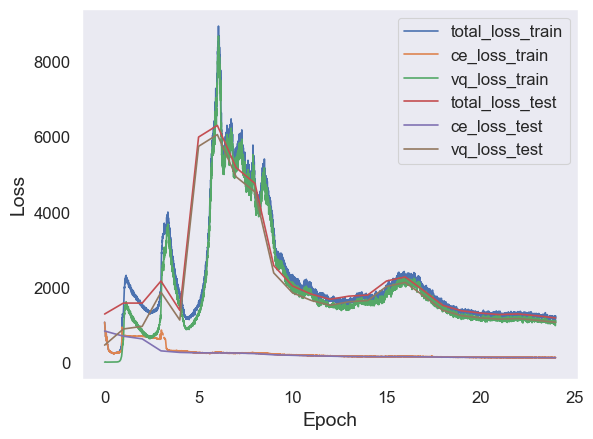

In [763]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 256   # any adequate value
EPOCHS = 25      # < 30
LR =  0.01         # < 1e-2
CE_SCALE = 2   # 0.01 < x < 30.0
# ====

#train_data, test_data = load_pickle("/content/mnist.pkl", flatten=False, binarize=True)

model = VQVAEModel(ce_loss_scale=CE_SCALE, latent_dim=16, num_embeddings=128)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    use_cuda=USE_CUDA,
    device=device,
    use_tqdm=True,
    lr=LR,
)

plot_training_curves(train_losses, test_losses)

Now we is able to sample from the trained model.

total_loss: 1176.4340
ce_loss: 117.9021
vq_loss: 1058.5319


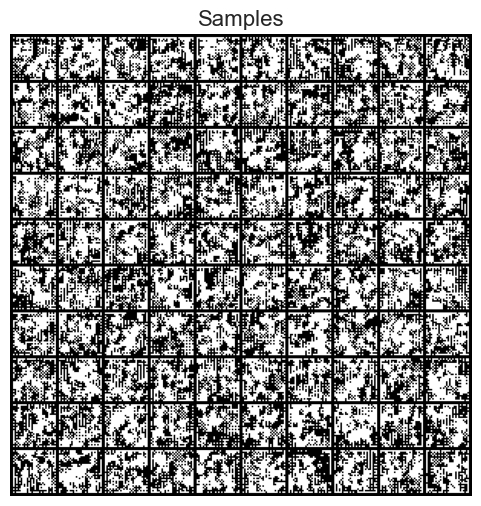

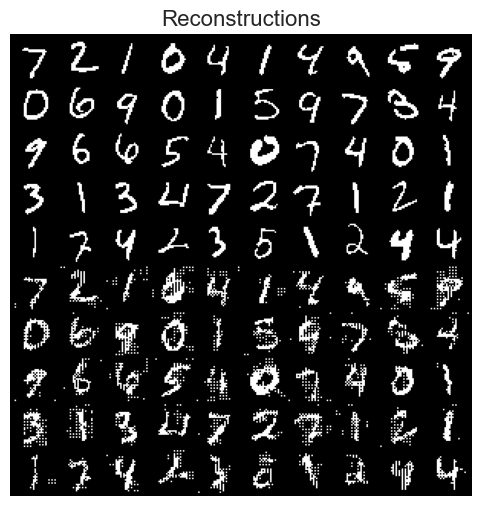

In [764]:
# Test losses
for key, value in test_losses.items():
    print("{}: {:.4f}".format(key, value[-1]))

# Samples
samples = model.sample(100)
samples = samples.astype("float32")
show_samples(samples, title="Samples")

# Reconstructions
x = next(iter(test_loader))[:50].to(device) #.cuda()
with torch.no_grad():
    decoded, _ = model(x)
    x_recon = model.sample_from_logits(decoded)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)
reconstructions = reconstructions.astype("float32")
show_samples(reconstructions, title="Reconstructions")

Probably you will get bad samples :(

Do not worry, may be it is OK, we will try to fix your samples! Make sure that reconstructions are almost perfect.

Here, we will visualize latent code indices for test images.

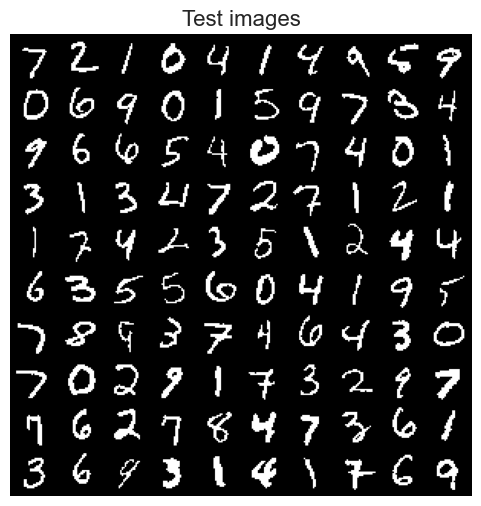

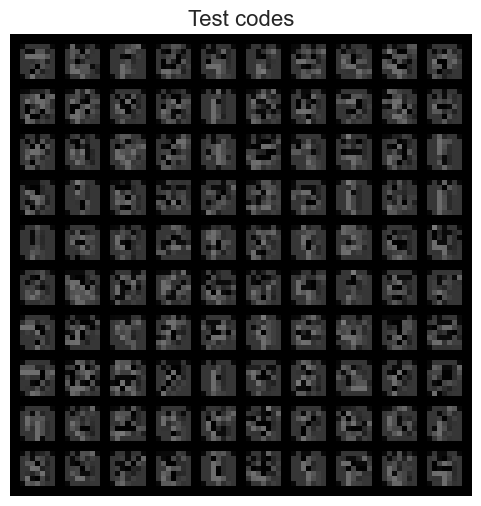

In [765]:
test_images = next(iter(test_loader))[:100]
x = test_images.to(device)
codebook_indices = model.get_indices(x).cpu().unsqueeze(1)

show_samples(test_images, "Test images")
show_samples(codebook_indices, "Test codes")

### Training of prior autoregressive model

The samples from our VQ-VAE model is not good enough. The authors of the original VQ-VAE paper proposed to train autoregressive model in the latent space after we trained VQ-VAE model.

Remember we have discussed **ELBO surgery** and **aggregrated posterior**. Let recall what do we have in VAE:
* **Training:** we get latent variables $\mathbf{z}$ from variational posterior $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$ for every object $\mathbf{x}$ and then applies decoder ($p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$). It means that in average decoder is applied to the latent variables from aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.
* **Inference:** We apply decoder to the latent variables from prior distribution $p(\mathbf{z})$.

It means that if our aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$ and prior $p(\mathbf{z})$ is too far from each other, then we get inconsistency.

So let train to remove this inconsistency. To be concrete, let train (autoregressive) model in the latent space that will try to predict samples from the aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.

We will use our good friend: PixelCNN model.

In [476]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [593]:
w = 7
k = 5
s = 1
p = 0

for p in [2, 2, 2]:
    w = (w - k + 2*p)/s + 1
    print(int(w))

7
7
7


In [766]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: str, in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(input)
        # ====

    def create_mask(self, mask_type: str) -> None:
        # ====
        # your code
        # do not forget about mask_type
        m = np.zeros(self.kernel_size) 
        r = self.kernel_size[0] // 2
        for i in range(r):
            m[i, :] = 1
        m[r, :r] = 1    
        if mask_type == 'B':
            m[r, r] = 1
        self.mask = torch.tensor(m, dtype=torch.float32).expand((self.out_channels, self.in_channels, 
                                 self.kernel_size[0], self.kernel_size[1]))
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [767]:
class PixelCNN(nn.Module):
    def __init__(
        self,
        num_embeddings: int = 128,
        input_shape: tuple = (7, 7),
        n_filters: int = 32,
        kernel_size: int = 5,
        n_layers: int = 5,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        self.net = []
        in_channels = num_embeddings
        for l in range(n_layers):
            
            mask_type = 'B'
            out_channels = n_filters
            if l == 0:
                mask_type = 'A'
            if l == n_layers - 1:
                out_channels = num_embeddings
            
            self.net.append(MaskedConv2d(mask_type, in_channels, out_channels, kernel_size=kernel_size))
            #if use_layer_norm:
            #    self.net.append(LayerNorm(n_filters))
            self.net.append(torch.nn.ReLU())    

            in_channels = out_channels
        self.net = torch.nn.Sequential(*self.net[:-1])
        
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # read the forward method carefully
        flattened = x.view((-1, 1))
        encodings = torch.zeros(flattened.shape[0], self.num_embeddings).to(device)
        encodings.scatter_(1, flattened, 1)
        encodings = encodings.view((-1, *self.input_shape, self.num_embeddings))
        encodings = encodings.permute((0, 3, 1, 2))
        out = self.net(encodings)
        out = out.view(-1, self.num_embeddings, 1, *self.input_shape)
        return out

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        #logits = self(x)
        #F.binary_cross_entropy(logits, x)
        logits = self(x)
        

        total_loss = F.cross_entropy(logits,
                                     x
                                    )
        
        print(total_loss)
        # ====
        return {"total_loss": total_loss}

    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape, dtype=torch.int64).to(device)
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(
                        probs, num_samples=1
                    ).squeeze(-1)
        return samples.cpu().numpy()


def test_pixelcnn():
    model = PixelCNN().to(device)
    print(model)
    x = torch.zeros((1, 1, 7, 7), dtype=torch.int64).to(device)
    output = model(x)
    assert output.shape == (1, 128, 1, 7, 7)
    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses
    samples = model.sample(10)
    assert samples.shape == (10, 1, 7, 7)


test_pixelcnn()

PixelCNN(
  (net): Sequential(
    (0): MaskedConv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaskedConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaskedConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaskedConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaskedConv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)
tensor(4.8359, device='mps:0', grad_fn=<NllLoss2DBackward0>)


Now we need to get our train and test samples. Our model will predict indices of the embeddings.

In [768]:
INPUT_SHAPE = (7, 7)  # input shape of your latent space

# ====
# your code
# you have to get indices of the emdeddings from the VQ-VAE model for train and test data

with torch.no_grad():
    z = model.encoder(torch.tensor(train_data).to(device))
    train_indices = model.vq_layer.get_code_indices(z).unsqueeze(1).detach().cpu().numpy()
    z = model.encoder(torch.tensor(test_data).to(device))
    test_indices = model.vq_layer.get_code_indices(z).unsqueeze(1).detach().cpu().numpy()

# ====

assert isinstance(train_indices, np.ndarray)
assert isinstance(test_indices, np.ndarray)
assert train_indices.shape == (60000, 1, *INPUT_SHAPE)
assert test_indices.shape == (10000, 1, *INPUT_SHAPE)

In [769]:
# ====
# your code
# choose these parameters by your own
EPOCHS =  5     # > 5
BATCH_SIZE = 256  # any adequate value
LR =  0.1         # < 1e-2
N_LAYERS =  5   # < 10
N_FILTERS = 64   # < 128
# ====

prior_model = PixelCNN(
    input_shape=INPUT_SHAPE, n_filters=N_FILTERS, kernel_size=5, n_layers=N_LAYERS
)

train_loader = data.DataLoader(train_indices, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_indices, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    prior_model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
    device=device
)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

tensor(4.8541, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(inf, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(inf, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(4.3833, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(4.6868, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.8357, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.5610, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.3088, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.2198, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.9670, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.9104, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.8809, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.8413, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.8302, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.7522, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.7276, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.6972, device='mps:0',

tensor(2.2187, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2352, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2454, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2203, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2131, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2620, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2392, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2345, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2512, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2152, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2400, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2226, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2177, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2156, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1952, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2381, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2517, device='m

 20%|█████████                                    | 1/5 [00:14<00:57, 14.27s/it]

tensor(2.2142, device='mps:0')
tensor(2.1828, device='mps:0')
tensor(2.2382, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2667, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2288, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2603, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2338, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2330, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2366, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2044, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2515, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2198, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2453, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2299, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2374, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2227, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2833, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2399, device='

tensor(2.2169, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2342, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2520, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2290, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2461, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2287, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2547, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2403, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2175, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1879, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2179, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2092, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2457, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2428, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2236, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2384, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2318, device='m

 40%|██████████████████                           | 2/5 [00:28<00:41, 13.97s/it]

tensor(2.3441, device='mps:0')
tensor(2.2682, device='mps:0')
tensor(2.2204, device='mps:0')
tensor(2.3425, device='mps:0')
tensor(2.2502, device='mps:0')
tensor(2.2650, device='mps:0')
tensor(2.2094, device='mps:0')
tensor(2.1947, device='mps:0')
tensor(2.2462, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2662, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2421, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2382, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2213, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2209, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2378, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2550, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2467, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2245, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2171, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2217, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2313, devic

tensor(2.2489, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2205, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2417, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2261, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2270, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2171, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2406, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2109, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2284, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2610, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2213, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2816, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2323, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2314, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2531, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2193, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2502, device='m

 60%|███████████████████████████                  | 3/5 [00:41<00:27, 13.86s/it]

tensor(2.1964, device='mps:0')
tensor(2.1890, device='mps:0')
tensor(2.2632, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2577, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2433, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2312, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2337, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2233, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2141, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2905, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2444, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2485, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2290, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2189, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2186, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2276, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2167, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2365, device='

tensor(2.2505, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2148, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2564, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2417, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2026, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2543, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2547, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2602, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2345, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2348, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2240, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2239, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2359, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1970, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2654, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2221, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2355, device='m

 80%|████████████████████████████████████         | 4/5 [00:55<00:13, 13.79s/it]

tensor(2.3324, device='mps:0')
tensor(2.2558, device='mps:0')
tensor(2.2572, device='mps:0')
tensor(2.1988, device='mps:0')
tensor(2.1973, device='mps:0')
tensor(2.2341, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2177, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2085, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2424, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2309, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2416, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2730, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2544, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2428, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2641, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2447, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2140, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1992, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2217, device='mps:0', grad_fn=<NllLoss2DBac

tensor(2.2793, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2327, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2335, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1924, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2568, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.1850, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2315, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2314, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2431, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2355, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2112, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2352, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2321, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2186, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2305, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2210, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(2.2382, device='m

100%|█████████████████████████████████████████████| 5/5 [01:09<00:00, 13.84s/it]

tensor(2.2734, device='mps:0')
tensor(2.2142, device='mps:0')
tensor(2.3401, device='mps:0')
tensor(2.2546, device='mps:0')
tensor(2.2596, device='mps:0')
tensor(2.2010, device='mps:0')
tensor(2.2000, device='mps:0')


Now we are ready to sample from our VQ-VAE model. The difference here that we will sample our embedding indices from the PixelCNN prior model instead of the Uniform prior distribution.

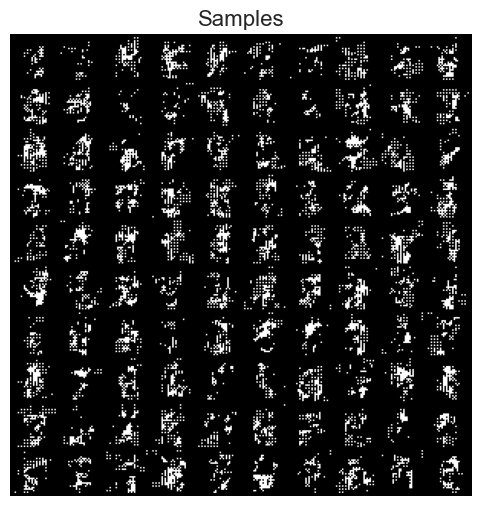

In [770]:
N_SAMPLES = 100
indices = prior_model.sample(N_SAMPLES).squeeze(1)

quantized = model.vq_layer.get_quantized(torch.Tensor(indices).type(torch.int64).to(device))
logits = model.decoder(quantized)
samples = model.sample_from_logits(logits)

samples = samples.astype("float32")
show_samples(samples, title="Samples")

Here you have to get samples with good enough quality!